In [11]:
import numpy as np

In [12]:
import matplotlib.pyplot as plt
from pydgrid.plot_bokeh import plot_results
import sympy as sym
import pydae.build as db
from pydae.grid_urisi import unb_ri_si
import json

In [18]:
data = {
        "buses":[
                 {"bus": "B1",  "pos_x":   0, "pos_y":   0, "units": "m", "U_kV":20.0},
                 {"bus": "B2",  "pos_x":  10, "pos_y":   0, "units": "m", "U_kV":0.4},
                 {"bus": "B3",  "pos_x": 100, "pos_y":  0, "units": "m", "U_kV":0.4},
                 {"bus": "B4",  "pos_x": 120, "pos_y":  0, "units": "m", "U_kV":0.4},
                 {"bus": "B2dc",  "pos_x":  10, "pos_y":  -50, "units": "m", "U_kV":0.4},
                 {"bus": "B3dc",  "pos_x": 100, "pos_y":  -50, "units": "m", "U_kV":0.4}
                ],
        "grid_formers":[
                        {"bus": "B1",
                        "bus_nodes": [1, 2, 3], "deg": [0, -120, -240],
                        "kV": [11.547, 11.547, 11.547]},
                        {"bus": "B2dc",
                        "bus_nodes":  [1, 2, 3], "deg": [0, 0, 0],
                        "kV": [0.8, 0.0,0.0]}
                       ],
        "transformers":[
                        {"bus_j": "B1",  "bus_k": "B2",  "S_n_kVA": 1000.0, "U_j_kV":20, "U_k_kV":0.4,
                         "R_cc_pu": 0.01, "X_cc_pu":0.04, "connection": "Dyn11",   "conductors_j": 3, "conductors_k": 4,
                         "monitor":True},
                       ],
        "lines":[
                 {"bus_j": "B2",  "bus_k": "B3",  "code": "UG1", "m": 200.0},
                 {"bus_j": "B3",  "bus_k": "B4",  "code": "UG1", "m": 10.0},
                 {"bus_j": "B2dc",  "bus_k": "B3dc",  "code": "UG1dc", "m": 200.0, 'monitor':True}
                ],
        "loads":[
                 {"bus": "B4" , "kVA": 0.0, "pf": 0.85,"type":"3P+N"}
                 #{"bus": "B3dc" ,  "bus_nodes": [1, 4], "kVA": 300.0, "pf": 1,"type":"1P+N"}
                ],
        "shunts":[
                 {"bus": "B2" , "R": 0.0001, "X": 0.0, "bus_nodes": [4,0]},
                 {"bus": "B2dc" , "R": 0.00001, "X": 0.0, "bus_nodes": [4,0]}
                 ],
        "line_codes":
            {"lv_cu_150":     {"Rph":0.167,"Xph":0.08, "Rn":0.167, "Xn": 0.08},
   "UG1dc":
    {"R":[[ 0.211,  0.0,  0.0,  0.0],
          [ 0.0,  0.211,  0.0,  0.0],
          [ 0.0,  0.0,  0.211,  0.0],
          [ 0.0,  0.0,  0.0,  0.211]],
     "X":[[ 0.0,  0.0,  0.0,  0.0],
          [ 0.0,  0.0,  0.0,  0.0],
          [ 0.0,  0.0,  0.0,  0.0],
          [ 0.0,  0.0,  0.0,  0.0]]
            }
       }}


In [19]:
grid = unb_ri_si(data)

v_B2_list = []
i_B2_list = []
v_B3_list = []
i_B3_list = []
for ph in ['a','b','c']:
    v_B2_ph_r,v_B2_ph_i = sym.symbols(f'v_B2_{ph}_r,v_B2_{ph}_i',real=True)
    v_B2_list += [v_B2_ph_r + 1j*v_B2_ph_i]
    i_B2_ph_r,i_B2_ph_i = sym.symbols(f'i_B2_{ph}_r,i_B2_{ph}_i',real=True)
    i_B2_list += [i_B2_ph_r + 1j*i_B2_ph_i]
    v_B3_ph_r,v_B3_ph_i = sym.symbols(f'v_B3_{ph}_r,v_B3_{ph}_i',real=True)
    v_B3_list += [v_B3_ph_r + 1j*v_B3_ph_i]
    i_B3_ph_r,i_B3_ph_i = sym.symbols(f'i_B3_{ph}_r,i_B3_{ph}_i',real=True)
    i_B3_list += [i_B3_ph_r + 1j*i_B3_ph_i]
v_B2_abc = sym.Matrix([v_B2_list]).T
i_B2_abc = sym.Matrix([i_B2_list]).T
v_B3_abc = sym.Matrix([v_B3_list]).T
i_B3_abc = sym.Matrix([i_B3_list]).T

s_B2 = v_B2_abc.T * sym.conjugate(i_B2_abc)
s_B2 = sym.expand(s_B2)
s_B3 = v_B3_abc.T * sym.conjugate(i_B3_abc)
s_B3 = sym.expand(s_B3)

i_l_B2dc_B3dc_a_r,i_l_B2dc_B3dc_n_r = sym.symbols('i_l_B2dc_B3dc_a_r,i_l_B2dc_B3dc_n_r')
v_B3dc_a_r,v_B3dc_n_r = sym.symbols('v_B3dc_a_r,v_B3dc_n_r')
v_B2dc_a_r,v_B2dc_n_r = sym.symbols('v_B2dc_a_r,v_B2dc_n_r')

p_B2dc,q_B2 = sym.symbols('p_B2dc,q_B2')
i_B2_a_r,i_B2_a_i = sym.symbols('i_B2_a_r,i_B2_a_i',real=True)


s_B2_a = v_B2_abc[0] * sym.conjugate(i_B2_abc[0])
s_B2_b = v_B2_abc[1] * sym.conjugate(i_B2_abc[1])
s_B2_c = v_B2_abc[2] * sym.conjugate(i_B2_abc[2])

eq_i_B2_a_r =  sym.re(s_B2_a) - p_B2dc/3
eq_i_B2_b_r =  sym.re(s_B2_b) - p_B2dc/3
eq_i_B2_c_r =  sym.re(s_B2_c) - p_B2dc/3
eq_i_B2_a_i =  sym.im(s_B2_a) - q_B2/3
eq_i_B2_b_i =  sym.im(s_B2_b) - q_B2/3
eq_i_B2_c_i =  sym.im(s_B2_c) - q_B2/3

i_rms = sym.sqrt(i_B2_a_r**2+i_B2_a_i**2+1) 
a = 2.92075867
b = 0.44961794
c = 0.02717091
p_simple = a + b*i_rms + c*i_rms*i_rms

p_vsc_loss = p_simple*6

eq_p_B2dc = p_B2dc + i_l_B2dc_B3dc_a_r * v_B2dc_a_r + i_l_B2dc_B3dc_n_r * v_B2dc_n_r + sym.Piecewise((p_vsc_loss, p_B2dc < 1), (p_vsc_loss, p_B2dc > 0),(0.0, True))

i_B2_a_r,i_B2_b_r,i_B2_c_r,i_B2_a_i,i_B2_b_i,i_B2_c_i,p_B2dc = sym.symbols('i_B2_a_r,i_B2_b_r,i_B2_c_r,i_B2_a_i,i_B2_b_i,i_B2_c_i,p_B2dc',real=True)
g_vsc = [eq_i_B2_a_r,eq_i_B2_b_r,eq_i_B2_c_r,eq_i_B2_a_i,eq_i_B2_b_i,eq_i_B2_c_i,eq_p_B2dc]
y_vsc = [i_B2_a_r,i_B2_b_r,i_B2_c_r,i_B2_a_i,i_B2_b_i,i_B2_c_i,p_B2dc]


p_B3,p_B3dc,q_B3 = sym.symbols('p_B3,p_B3dc,q_B3',real=True)
i_B3dc_a_r,i_B3dc_n_r = sym.symbols('i_B3dc_a_r,i_B3dc_n_r',real=True)

s_B3_a = v_B3_abc[0] * sym.conjugate(i_B3_abc[0])
s_B3_b = v_B3_abc[1] * sym.conjugate(i_B3_abc[1])
s_B3_c = v_B3_abc[2] * sym.conjugate(i_B3_abc[2])

eq_i_B3_a_r =  sym.re(s_B3_a) - p_B3/3
eq_i_B3_b_r =  sym.re(s_B3_b) - p_B3/3
eq_i_B3_c_r =  sym.re(s_B3_c) - p_B3/3
eq_i_B3_a_i =  sym.im(s_B3_a) - q_B3/3
eq_i_B3_b_i =  sym.im(s_B3_b) - q_B3/3
eq_i_B3_c_i =  sym.im(s_B3_c) - q_B3/3

i_B3_a_r,i_B3_b_r,i_B3_c_r,i_B3_a_i,i_B3_b_i,i_B3_c_i,p_B3dc = sym.symbols('i_B3_a_r,i_B3_b_r,i_B3_c_r,i_B3_a_i,i_B3_b_i,i_B3_c_i,p_B3dc',real=True)

i_rms = sym.sqrt(i_B3_a_r**2+i_B3_a_i**2+1) 
a = 2.92075867
b = 0.44961794
c = 0.02717091
p_simple = a + b*i_rms + c*i_rms*i_rms

p_vsc_loss = p_simple*6

eq_p_B3dc = p_B3dc - p_B3 - sym.Piecewise((p_vsc_loss, p_B3dc < 1), (p_vsc_loss, p_B3dc > 0),(0.0, True))
eq_i_B3dc_a_r = i_B3dc_a_r + p_B3dc/(v_B3dc_a_r-v_B3dc_n_r+1e-8)
eq_i_B3dc_n_r = i_B3dc_n_r + p_B3dc/(v_B3dc_n_r-v_B3dc_a_r+1e-8)

g_vsc += [eq_i_B3_a_r,eq_i_B3_b_r,eq_i_B3_c_r,eq_i_B3_a_i,eq_i_B3_b_i,eq_i_B3_c_i,eq_p_B3dc,eq_i_B3dc_a_r,eq_i_B3dc_n_r]
y_vsc += [i_B3_a_r,i_B3_b_r,i_B3_c_r,i_B3_a_i,i_B3_b_i,i_B3_c_i,p_B3dc,i_B3dc_a_r,i_B3dc_n_r]
u_vsc = {'p_B3':0.0,'q_B3':0.0,'q_B2':0.0}
xy_0_dict_vsc = {'v_B3dc_a_r':800.0,'v_B3dc_n_r':10.0}

[[0.211+0.j 0.   +0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.211+0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.211+0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.211+0.j]]


In [20]:
params_dict  = grid.dae['params']
f_list = grid.dae['f']
x_list = grid.dae['x']
g_list = grid.dae['g'] + g_vsc
y_list = grid.dae['y'] + y_vsc
u_dict = grid.dae['u']
for ph in ['a','b','c']:
    u_dict.pop(f'i_B2_{ph}_r')
    u_dict.pop(f'i_B2_{ph}_i')
for ph in ['a','n']:
    u_dict.pop(f'i_B3dc_{ph}_r')

u_dict.update(u_vsc)
a = sym.Symbol('a')
grid.dae['xy_0_dict'].update(xy_0_dict_vsc)

h_dict = grid.dae['h_v_m_dict']

sys_dict = {'name':'grid_trafo_2bus',
           'params_dict':params_dict,
           'f_list':f_list,
           'g_list':g_list,
           'x_list':x_list,
           'y_ini_list':y_list,
           'y_run_list':y_list,
           'u_run_dict':u_dict,
           'u_ini_dict':u_dict,
           'h_dict':h_dict
           }

db.system(sys_dict)
db.sys2num(sys_dict)

data = json.dumps(grid.dae['xy_0_dict'], indent=4)
fobj = open("xy_0_dict.json","w")
fobj.write(data)
fobj.close()

system without dynamic equations, adding dummy dynamic equation


In [21]:
plot_results(grid)

Figure(id='1300', ...)

In [17]:
u_dict

{'v_B1_a_r': 11547.0,
 'v_B1_a_i': 0.0,
 'v_B1_b_r': -5773.499999999997,
 'v_B1_b_i': -9999.995337498915,
 'v_B1_c_r': -5773.5000000000055,
 'v_B1_c_i': 9999.99533749891,
 'v_B2dc_a_r': 800.0,
 'v_B2dc_a_i': 0.0,
 'v_B2dc_b_r': 0.0,
 'v_B2dc_b_i': 0.0,
 'v_B2dc_c_r': 0.0,
 'v_B2dc_c_i': 0.0,
 'i_B4_n_r': 0.0,
 'i_B4_n_i': 0.0,
 'i_B2_n_r': 0.0,
 'i_B2_n_i': 0.0,
 'i_B3_a_r': 0.0,
 'i_B3_a_i': 0.0,
 'i_B3_b_r': 0.0,
 'i_B3_b_i': 0.0,
 'i_B3_c_r': 0.0,
 'i_B3_c_i': 0.0,
 'i_B3_n_r': 0.0,
 'i_B3_n_i': 0.0,
 'i_B2dc_n_r': 0.0,
 'i_B2dc_n_i': 0.0,
 'i_B3dc_a_i': 0.0,
 'i_B3dc_b_r': 0.0,
 'i_B3dc_b_i': 0.0,
 'i_B3dc_c_r': 0.0,
 'i_B3dc_c_i': 0.0,
 'i_B3dc_n_i': 0.0,
 'p_B4_a': 0.0,
 'q_B4_a': -0.0,
 'p_B4_b': -0.0,
 'q_B4_b': 0.0,
 'p_B4_c': 0.0,
 'q_B4_c': 0.0,
 'p_B3': 0.0,
 'q_B3': 0.0,
 'q_B2': 0.0,
 'u_dummy': 1.0}

In [10]:
y_list

[v_B4_a_r,
 v_B4_a_i,
 v_B4_b_r,
 v_B4_b_i,
 v_B4_c_r,
 v_B4_c_i,
 v_B4_n_r,
 v_B4_n_i,
 v_B2_a_r,
 v_B2_a_i,
 v_B2_b_r,
 v_B2_b_i,
 v_B2_c_r,
 v_B2_c_i,
 v_B2_n_r,
 v_B2_n_i,
 v_B3_a_r,
 v_B3_a_i,
 v_B3_b_r,
 v_B3_b_i,
 v_B3_c_r,
 v_B3_c_i,
 v_B3_n_r,
 v_B3_n_i,
 v_B2dc_n_r,
 v_B2dc_n_i,
 v_B3dc_a_r,
 v_B3dc_a_i,
 v_B3dc_b_r,
 v_B3dc_b_i,
 v_B3dc_c_r,
 v_B3dc_c_i,
 v_B3dc_n_r,
 v_B3dc_n_i,
 i_t_B1_B2_a_r,
 i_t_B1_B2_a_i,
 i_t_B1_B2_b_r,
 i_t_B1_B2_b_i,
 i_t_B1_B2_c_r,
 i_t_B1_B2_c_i,
 i_l_B2dc_B3dc_a_r,
 i_l_B2dc_B3dc_a_i,
 i_l_B2dc_B3dc_b_r,
 i_l_B2dc_B3dc_b_i,
 i_l_B2dc_B3dc_c_r,
 i_l_B2dc_B3dc_c_i,
 i_l_B2dc_B3dc_n_r,
 i_l_B2dc_B3dc_n_i,
 i_B4_a_r,
 i_B4_a_i,
 i_B4_b_r,
 i_B4_b_i,
 i_B4_c_r,
 i_B4_c_i,
 i_B4_n_r,
 i_B4_n_i,
 i_B2_a_r,
 i_B2_b_r,
 i_B2_c_r,
 i_B2_a_i,
 i_B2_b_i,
 i_B2_c_i,
 p_B2dc,
 i_B3_a_r,
 i_B3_b_r,
 i_B3_c_r,
 i_B3_a_i,
 i_B3_b_i,
 i_B3_c_i,
 p_B3dc,
 i_B3dc_a_r,
 i_B3dc_n_r]

## Losses

In [22]:
params_30A = {
 'a_i': 1.95773625,
 'b_i': 0.32430738,
 'c_i':-0.22694456,
 'd_i': 0.0155737 ,
 'e_i':-0.01093976,
 'a_d': 0.96302242,
 'b_d': 0.02653386,
 'c_d': 0.05055759,
 'd_d': 0.01328264,
 'e_d': 0.01394945,
 'R_th_igbt_sink': 0.5167999063238943,
 'R_th_diode_sink': 0.8394969099630814,
 'R_th_sink_a': 0.6619445743152772}

params = params_30A

a_i = params['a_i']
b_i = params['b_i']
c_i = params['c_i']
d_i = params['d_i']
e_i = params['e_i']
a_d = params['a_d']
b_d = params['b_d']
c_d = params['c_d']
d_d = params['d_d']
e_d = params['e_d']

m = 0.95
fp = 0.8
i_rms = np.linspace(0,30,600)
p_igbt  = a_i + (b_i - c_i*m*fp)*i_rms + (d_i - e_i*m*fp)*i_rms*i_rms
p_diode = a_d + (b_d - c_d*m*fp)*i_rms + (d_d - e_d*m*fp)*i_rms*i_rms

p_switch = p_igbt + p_diode
#print(f'p_switch = {p_switch} W')

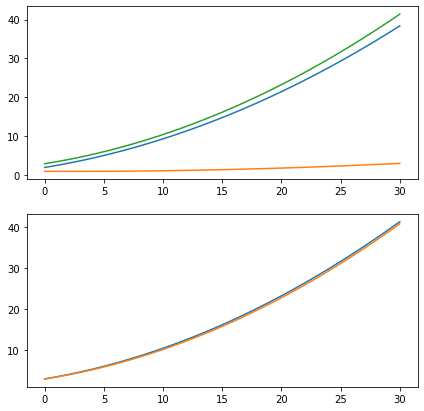

In [42]:
fig_1,  axes   = plt.subplots(nrows=2,ncols=1, figsize=(7, 7))

m = 0.95
fp = 0.8
i_rms = np.linspace(0,30,600)
p_igbt  = a_i + (b_i - c_i*m*fp)*i_rms + (d_i - e_i*m*fp)*i_rms*i_rms
p_diode = a_d + (b_d - c_d*m*fp)*i_rms + (d_d - e_d*m*fp)*i_rms*i_rms

p_switch = p_igbt + p_diode

axes[0].plot(i_rms,p_igbt)
axes[0].plot(i_rms,p_diode)
axes[0].plot(i_rms,p_switch)
axes[1].plot(i_rms,p_switch)

m = 0.4
fp = 0.8
i_rms = np.linspace(0,30,600)
p_igbt  = a_i + (b_i - c_i*m*fp)*i_rms + (d_i - e_i*m*fp)*i_rms*i_rms
p_diode = a_d + (b_d - c_d*m*fp)*i_rms + (d_d - e_d*m*fp)*i_rms*i_rms

p_switch = p_igbt + p_diode

a =  2.92075867
b = 0.4496179432
c = 0.0271709136
p_simple = a + b*i_rms + c*i_rms*i_rms
axes[1].plot(i_rms,p_simple)

In [44]:
i_rms*400*np.sqrt(3)

array([    0.        ,    34.69884756,    69.39769513,   104.09654269,
         138.79539026,   173.49423782,   208.19308538,   242.89193295,
         277.59078051,   312.28962808,   346.98847564,   381.6873232 ,
         416.38617077,   451.08501833,   485.7838659 ,   520.48271346,
         555.18156102,   589.88040859,   624.57925615,   659.27810372,
         693.97695128,   728.67579884,   763.37464641,   798.07349397,
         832.77234154,   867.4711891 ,   902.17003666,   936.86888423,
         971.56773179,  1006.26657936,  1040.96542692,  1075.66427448,
        1110.36312205,  1145.06196961,  1179.76081718,  1214.45966474,
        1249.1585123 ,  1283.85735987,  1318.55620743,  1353.255055  ,
        1387.95390256,  1422.65275012,  1457.35159769,  1492.05044525,
        1526.74929282,  1561.44814038,  1596.14698794,  1630.84583551,
        1665.54468307,  1700.24353064,  1734.9423782 ,  1769.64122576,
        1804.34007333,  1839.03892089,  1873.73776846,  1908.43661602,
      

In [37]:
m = 0.7
fp= 0.8
b = (b_i - c_i*m*fp + b_d - c_d*m*fp)
c = (d_i - e_i*m*fp + d_d - e_d*m*fp)
print(f'b = {b}')
print(f'c = {c}')

b = 0.4496179432
c = 0.027170913600000002


In [40]:
a_i+a_d

2.92075867

In [47]:
6*40/20000*100

1.2